# Learn

In [1]:
import json
import os
from pathlib import Path
import sys
import time

import joblib
import numpy as np
import sklearn.ensemble
import sklearn.feature_selection
import sklearn.metrics
import sklearn.model_selection
from tqdm.auto import tqdm

root = str(Path.cwd().parents[1])
sys.path.append(root)
os.chdir(root)
import src

In [ ]:
X, y, s = src.get_Xys()
y = y>1
ys = y + 3*s

skf = sklearn.model_selection.StratifiedKFold(shuffle=True, random_state=42)
folds = list(skf.split(X=X, y=ys))

iterator = [
    (orthogonality, int(max_depth), n_bins, fold, train_idx, test_idx) 
    for n_bins in [2, 10]
    for orthogonality in np.linspace(0, 1, 21)
    for max_depth in np.arange(1, 11)
    for fold, (train_idx, test_idx) in enumerate(folds)
]

count = 0
for ortho, max_depth, n_bins, fold, train_idx, test_idx in tqdm(iterator, 
                                                                mininterval=0, 
                                                                miniters=1):
    assert isinstance(max_depth, int)
    assert isinstance(n_bins, int)
    filepath = f'cache/FRF_v3_A/Ao-{max_depth}-{ortho:.2f}-{fold}-{n_bins}'
    if not os.path.isfile(filepath + '.pkl'):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        s_train, s_test = s[train_idx], s[test_idx]        
        
        vt = sklearn.feature_selection.VarianceThreshold()
        vt.fit(X_train)
        X_train = vt.transform(X_train)
        X_test = vt.transform(X_test)
        
        clf = src.FairRandomForestClassifier(
            max_depth=max_depth, 
            n_estimators=100, 
            orthogonality=ortho, 
            n_jobs=100, 
            n_bins=n_bins
        ) 
        start = time.time()
        clf.fit(X_train, y_train, s_train)
        joblib.dump(clf, filepath + '.pkl')
        fit_time = time.time() - start                   

# Predict

In [ ]:
import os

import joblib
import numpy as np
import sklearn.feature_selection
import sklearn.model_selection
from tqdm.auto import tqdm

import src

X, y, s = src.get_Xys()
y = y>1
ys = y + 3*s

skf = sklearn.model_selection.StratifiedKFold(shuffle=True, random_state=42)
folds = list(skf.split(X=X, y=ys))

iterator = [
    (orthogonality, int(max_depth), n_bins, fold, train_idx, test_idx) 
    for orthogonality in np.linspace(0, 1, 11)
    for max_depth in np.arange(1, 11)
    for n_bins in [2, 10]
    for fold, (train_idx, test_idx) in enumerate(folds)
]

for ortho, max_depth, n_bins, fold, train_idx, test_idx in tqdm(iterator,
                                                                mininterval=0,
                                                                miniters=1):
    assert isinstance(max_depth, int)
    assert isinstance(n_bins, int)
    filepath = f'cache/FRF_v3_A/Ao-{max_depth}-{ortho:.1f}-{fold}-{n_bins}'

    if not os.path.isfile(filepath + '.npy'):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        s_train, s_test = s[train_idx], s[test_idx]

        vt = sklearn.feature_selection.VarianceThreshold()
        vt.fit(X_train)
        X_train = vt.transform(X_train)
        X_test = vt.transform(X_test) 

        assert os.path.isfile(filepath + '.pkl')
        clf = joblib.load(filepath + '.pkl')
        y_score = clf.predict_proba(X_test)[:,1] #type: ignore
        np.save(filepath + '.npy', y_score)

# Measure

In [ ]:
import json
import os

import joblib
import numpy as np
import sklearn.model_selection
from tqdm.auto import tqdm

import src

overwrite=True

X, y, s = src.get_Xys()
y = y>1
ys = y + 3*s

skf = sklearn.model_selection.StratifiedKFold(shuffle=True, random_state=42)
folds = list(skf.split(X=X, y=ys))

iterator = [
    (ortho, int(max_depth), n_bins, fold, train_idx, test_idx) 
    for ortho in np.linspace(0, 1, 11)
    for max_depth in np.arange(1, 11)
    for n_bins in [2, 10]
    for fold, (train_idx, test_idx) in enumerate(folds)
]

results = list()

for ortho, max_depth, n_bins, fold, train_idx, test_idx in tqdm(iterator):
    assert isinstance(max_depth, int)
    assert isinstance(n_bins, int)
    filepath = f'cache/FRF_v3_A/Ao-{max_depth}-{ortho:.1f}-{fold}-{n_bins}'

    if not os.path.isfile(filepath + '.json') or overwrite:
        y_test, s_test = y[test_idx], s[test_idx]

        assert os.path.isfile(filepath + '.npy')
        y_score = np.load(filepath + '.npy')
        
        measures = src.get_measures(y_test, y_score, s_test)
        
        result_this_run_ = {
            'fold': fold,
            'max_depth': max_depth,
            'orthogonality': ortho,
            'n_bins': n_bins,
            **measures
        }
        with open(filepath + '.json', 'w') as file:
            json.dump(result_this_run_, file)
    else:
        with open(filepath + '.json') as file:
            result_this_run_ = json.load(file)
    results.append(result_this_run_)
with open('cache/FRF_v3_A_non-nested.json', 'w') as file:
    json.dump(results, file)


# Analysis

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.model_selection

import src

data = (
    pd.read_json("cache/FRF_v3_A_non-nested.json")
    .groupby(['max_depth', 'orthogonality', 'n_bins'])
    .mean()
    .reset_index()
    .sort_values('auc_y', ascending=False)
    .drop_duplicates(subset=['orthogonality'])
    .sort_values('orthogonality')
)
data

X, y, s = src.get_Xys()
y = y<2
title_prefix = f'Fair Random Forest (non-nested gridsearch) | Scenario A\nmax_depth=[1-10] | n_estimators=100 | n_bins=[2,10]'
base_rate = np.mean(y)
base_rate_black = np.mean(y[s])
base_rate_white = np.mean(y[~s])

In [2]:
data

,max_depth,orthogonality,n_bins,fold,auc_y,auc_s,threshold,proportion_predicted_ok_white,proportion_predicted_ok_black,disparate_impact,disparate_impact_epsilon,false_ok_white,false_ok_black,true_ok_white,true_ok_black,equalized_odds_false_ok,equalized_odds_true_ok,equalized_odds_epsilon
89,5,0.0,10,2,0.693053,0.642398,0.123073,0.952673,0.802846,0.842746,0.157254,0.853140,0.640247,0.957167,0.859515,0.212893,0.097651,0.212893
91,5,0.1,10,2,0.693718,0.637416,0.121465,0.952214,0.809665,0.850308,0.149692,0.854106,0.661733,0.956643,0.861185,0.192374,0.095458,0.192374
93,5,0.2,10,2,0.691953,0.627307,0.119898,0.951171,0.825166,0.867553,0.132447,0.846377,0.692943,0.955902,0.871224,0.153434,0.084678,0.167425
73,4,0.3,10,2,0.680824,0.589901,0.108751,0.949084,0.856154,0.902112,0.097888,0.845411,0.733678,0.953764,0.898818,0.111733,0.054946,0.111733
75,4,0.4,10,2,0.672128,0.565573,0.106416,0.947039,0.886535,0.936125,0.063875,0.835749,0.791308,0.952063,0.919725,0.051355,0.032339,0.058995
77,4,0.5,10,2,0.666232,0.547309,0.100112,0.945829,0.904513,0.956328,0.043672,0.825121,0.822490,0.951278,0.933096,0.027891,0.018182,0.030423
35,2,0.6,10,2,0.651906,0.527806,0.081956,0.944952,0.917537,0.970994,0.029006,0.841546,0.858434,0.949621,0.938117,0.023500,0.011503,0.027157
59,3,0.7,10,2,0.646391,0.528373,0.254893,0.944368,0.926216,0.980788,0.019212,0.849275,0.870511,0.948661,0.945638,0.045308,0.009553,0.045308
17,1,0.8,10,2,0.643924,0.527832,0.067075,0.944618,0.922522,0.976620,0.023380,0.844444,0.863282,0.949141,0.943145,0.028383,0.016892,0.031828
19,1,0.9,10,2,0.636568,0.531472,0.064402,0.944326,0.926860,0.981524,0.018476,0.853140,0.884911,0.948443,0.941461,0.033610,0.020570,0.040186


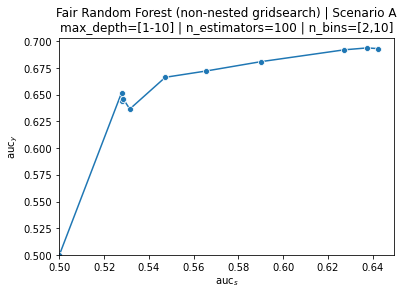

In [3]:
sns.lineplot(data=data, x='auc_s', y='auc_y', marker='o')
plt.xlim(.5)
plt.ylim(.5)
plt.xlabel(r'$\mathrm{auc}_s$')
plt.ylabel(r'$\mathrm{auc}_y$')
plt.title(title_prefix);

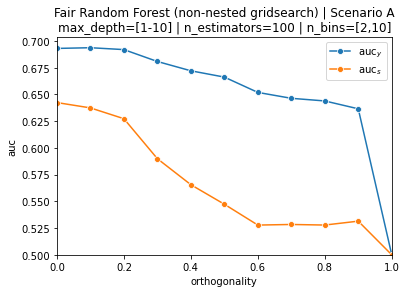

In [4]:
sns.lineplot(data=data, x='orthogonality', y='auc_y', label=r'$\mathrm{auc}_y$', marker='o')
sns.lineplot(data=data, x='orthogonality', y='auc_s', color='C1', label=r'$\mathrm{auc}_s$', marker='o')
plt.xlim(0, 1)
plt.ylim(.5)
plt.xlabel('orthogonality')
plt.ylabel('auc')
plt.title(title_prefix);

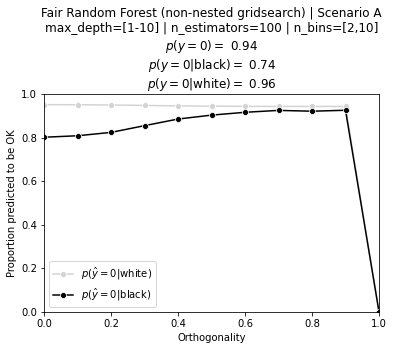

In [5]:
sns.lineplot(data=data, x='orthogonality', y='proportion_predicted_ok_white', color='lightgrey', label=r'$p(\haty=0|\mathrm{white})$', marker='o')
sns.lineplot(data=data, x='orthogonality', y='proportion_predicted_ok_black', color='black', label=r'$p(\haty=0|\mathrm{black})$', marker='o')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('Orthogonality')
plt.ylabel('Proportion predicted to be OK')
title_first_line = 'Fair Random Forest (non-nested gridsearch) | Scenario A'
title_second_line = 'max_depth=[1-10] | n_estimators=100 | n_bins=2'
title_third_line = f'$p(y=0)=$ {base_rate:.2f}'
title_fourth_line = f'$p(y=0|\mathrm{{black}})=$ {base_rate_black:.2f}'
title_fifth_line = f'$p(y=0|\mathrm{{white}})=$ {base_rate_white:.2f}'
plt.title(title_prefix + '\n' + title_third_line + '\n' + title_fourth_line + '\n' + title_fifth_line);

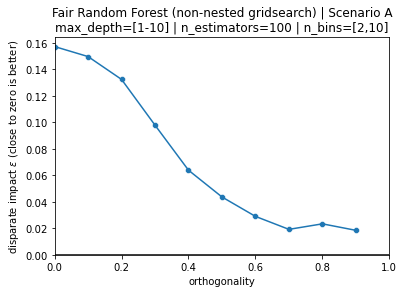

In [6]:
sns.lineplot(data=data, x='orthogonality', y='disparate_impact_epsilon')
sns.scatterplot(data=data, x='orthogonality', y='disparate_impact_epsilon')
plt.xlim(0, 1)
plt.ylim(0)
plt.xlabel('orthogonality')
plt.axhline(0, ls='-', color='black')
plt.ylabel(r'disparate impact $\epsilon$ (close to zero is better)')
plt.title(title_prefix);

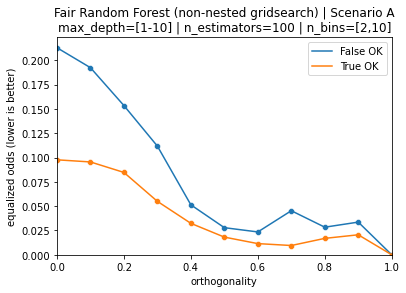

In [7]:
sns.lineplot(data=data, x='orthogonality', y='equalized_odds_false_ok', label='False OK')
sns.lineplot(data=data, x='orthogonality', y='equalized_odds_true_ok', label='True OK', color='C1')
sns.scatterplot(data=data, x='orthogonality', y='equalized_odds_false_ok')
sns.scatterplot(data=data, x='orthogonality', y='equalized_odds_true_ok', color='C1')
plt.xlim(0, 1)
plt.ylim(0)
plt.xlabel('orthogonality')
plt.ylabel(r'equalized odds (lower is better)')
plt.title(title_prefix);

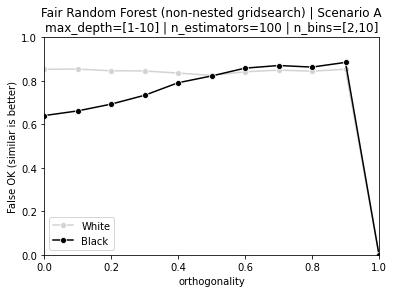

In [8]:
sns.lineplot(data=data, x='orthogonality', y='false_ok_white', label='White', marker='o', color='lightgrey')
sns.lineplot(data=data, x='orthogonality', y='false_ok_black', label='Black', marker='o', color='black')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('orthogonality')
plt.ylabel(r'False OK (similar is better)')
plt.title(title_prefix);

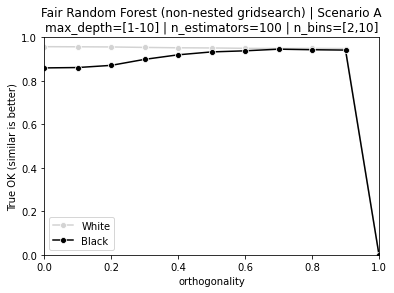

In [9]:
sns.lineplot(data=data, x='orthogonality', y='true_ok_white', label='White', marker='o', color='lightgrey')
sns.lineplot(data=data, x='orthogonality', y='true_ok_black', label='Black', marker='o', color='black')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('orthogonality')
plt.ylabel(r'True OK (similar is better)')
plt.title(title_prefix);